# MLEA : Arbres de Décisions

## ID3 : ToyProblem

#### Data

In [3]:
from io import StringIO
from graphviz import Digraph
import pandas as pd
import numpy as np

In [4]:
csv_data = StringIO("""
Outlook,Temperature,Humidity,Wind
Sunny,Hot,High,Weak
Sunny,Hot,High,Strong
Overcast,Hot,High,Weak
Rain,Mild,High,Weak
Rain,Cool,Normal,Weak
Rain,Cool,Normal,Strong
Overcast,Cool,Normal,Strong
Sunny,Mild,High,Weak
Sunny,Cool,Normal,Weak
Rain,Mild,Normal,Weak
Sunny,Mild,Normal,Strong
Overcast,Mild,High,Strong
Overcast,Hot,Normal,Weak
Rain,Mild,High,Strong
""")

In [5]:
df=pd.read_csv(csv_data, sep=',',header=0)

In [6]:
print(df.index[df.loc[:, 'Outlook'] == 'Sunny'])
df

Int64Index([0, 1, 7, 8, 10], dtype='int64')


,Outlook,Temperature,Humidity,Wind
0,Sunny,Hot,High,Weak
1,Sunny,Hot,High,Strong
2,Overcast,Hot,High,Weak
3,Rain,Mild,High,Weak
4,Rain,Cool,Normal,Weak
5,Rain,Cool,Normal,Strong
6,Overcast,Cool,Normal,Strong
7,Sunny,Mild,High,Weak
8,Sunny,Cool,Normal,Weak
9,Rain,Mild,Normal,Weak


In [7]:
x = df
labels = np.array(["No", "No", "Yes", "Yes", "Yes", "No", "Yes", "No", "Yes", "Yes", "Yes", "Yes", "Yes", "No"])

### Implementation

#### Tree structure for ID3

In [105]:
class Node:
    
    ID = 0
    
    """Simple custom tree structures containing the ID3 data.
    
    """
    
    def __init__(self, dot, parent_attrib):
        self.attribute = None
        self.label = None
        self.parent_attrib = parent_attrib
        self.dot = dot
        self.children = {}
    
    def setLabel(self, label, link_name):
        """Sets the label of the current node.
        
        Parameters
        ----------
        
        label:
            Value of the label.
    
        """

        self.label = label
        node_label = "{}_{}".format(label, Node.ID)
        self.dot.node(node_label, label, color='green', shape='diamond')
        self.dot.edge(self.parent_attrib, node_label, label=link_name)

        # This static ID is a way to create
        # new label node, without having conflict.
        Node.ID = Node.ID + 1
    
    def update_dot(self, entropy):
        """Updates the value of the node, by specifying its atrribute,
        as well as making the link in the dot tree, for rendering.
        
        Parameters
        ----------
        
        attribute:
            Value of the attribute of the node.
    
        """
        
        # This is gross, but it allows to easily
        # pretty print the tree.
        attribute = self.attribute
        attr_str = "{}\nEntropy: {:.2f}".format(attribute, entropy)
        self.dot.node(attribute, attr_str)
        for child_key in self.children:
            child_attr = self.children[child_key].attribute
            if not(child_attr is None):
                self.dot.edge(attribute, child_attr, label=child_key)
        
    
    def add(self, idx, attribute=None):
        """Adds a new node as a child, using a custom edge
        value.
        
        Parameters
        ----------
        
        idx:
            Name of the edge added between self and the new node.
    
        """
        child = Node(self.dot, self.attribute)
        self.children[idx] = child
        return child

In [136]:
class ID3:
    
    @staticmethod
    def entropy(s, unique_labels):
        """Computes the entropy of a given set of values.
        
        Parameters
        ----------
        
        s:
            The set on which the entropy is computed.
    
        """
        # Used to avoid having invalid value in the logarithm.
        EPSILON = 0.0001
        nb_rows = len(s)
        entropy = 0.0
        for label in unique_labels:
            label_count = 0
            for i in range(0, nb_rows):
                if s[i] == label:
                    label_count += 1
            proba = (label_count / nb_rows) + 0.0001
            entropy += - proba * np.log2(proba)
        return entropy
    
    @staticmethod
    def gain(s, target_attrib, attributes, x, y, unique_labels):
        """Computes the gain .
        
        Parameters
        ----------
        
        s:
            The set on which the entropy is computed.
    
        """
        
        column = x.ix[:, target_attrib][s]
        values = attributes[target_attrib]
        nb_rows = len(s)
        
        gain = ID3.entropy(y[s], unique_labels)
        
        for value in values:
            indices = column.index[column.loc[:] == value]
            factor = len(indices) / nb_rows
            y_new = y[indices.tolist()]
            if (len(y_new) == 0):
                continue
            gain += - factor * ID3.entropy(y_new, unique_labels)
            
        return gain
    
    def __build(self, node, label, x, y, s, attributes, unique_labels):
        unique = np.unique(y[s])
        if unique.shape[0] < 2:
            #node.label = unique[0]
            node.setLabel(unique[0], label)
            return

        # Choose the best attribute for classification.
        best_gain = -0.01
        best_attribute = None
        for attr in attributes:
            gain = ID3.gain(s, attr, attributes, x, y, unique_labels)
            if gain > best_gain:
                best_gain = gain
                best_attribute = attr
        
        column = x.ix[s, best_attribute]
        values = attributes[best_attribute]
        
        del attributes[best_attribute]
        if len(attributes) == 0:
            return
        
        # Updates the name and the branche names
        #if node.attribute == None:
        node.attribute = best_attribute
    
        for value in values:
            # Adds a child node pointed by value, and
            # then we can recursively create it.
            new_s = column.index[column.loc[:] == value].tolist()
            child = node.add(value)
            self.__build(child, value, x, y, new_s, dict(attributes), unique_labels)
            
        entropy_val = ID3.entropy(y[s], unique_labels)
        node.update_dot(entropy_val)
    
    def __init__(self, x, y):
        unique_labels = set(y)
        
        # This maps store, for all attributes, a
        # set of unique values.
        unique_attributes = {}
        for column in enumerate(x.columns):
            column_id = column[1]
            unique_attributes[column_id] = set(x.ix[:, column_id])
        
        # Creates the Digraph used for pretty printing.
        # We will shape it to make it look good!
        self.dot = Digraph(comment='The Round Table')
        self.dot.attr('node', shape='component')
        
        s = [i for i in range(0, len(y))]
        self.root = Node(self.dot, None)
        self.__build(self.root, None, x, y, s, unique_attributes, unique_labels)
        
    def predict(self, x):
        node = self.root
        label = None
        while True:
            # We found the leaf node, return the label
            if len(node.children) == 0:
                return node.label
            
            key = node.attribute
            if not(key in x):
                raise ValueError('\'{}\' is not an attribute of x'.format(key))
            
            value = x[key]
            # This value does not exist in the tree
            if not(value in node.children):
                raise ValueError('\'{}\' is not a value in the tree'.format(value))

            branch = x[node.attribute]
            # We are in the middle of the 
            node = node.children[branch]

### Utils for prediction

The function below will be used to test the prediction

In [149]:
def performance(x_train, y_train, **kwargs):
    x_test = kwargs.get("x_test", x_train)
    y_test = kwargs.get("y_test", y_train)
    
    # Training: builds the tree
    tree = ID3(x_train, y_train)
    
    # Counts the number of success
    nb_elt = len(y_train)
    res = 0
    for i in range(0, nb_elt):
        pred = tree.predict(x_test.loc[i])
        res = res + 1 if pred == y_test[i] else res
    res = res / nb_elt 
    return (res * 100.0)

#### PlayTennis test by Hand

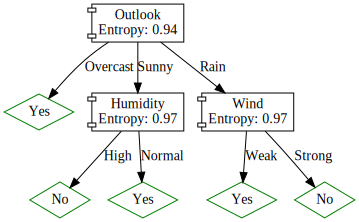

In [150]:
tree = ID3(x, labels)
tree.dot

In [151]:
test = df.loc[0]
print("Test with row 0, answer is {}".format(tree.predict(df.loc[0])))

Test with row 0, answer is No


#### PlayTennis test on train

In [153]:
print('PlayTennis, test on train ->')
print('Accuracy: {}%'.format(performance(x, labels)))

PlayTennis, test on train ->
Accuracy: 100.0%


## ID3 : Mushroom